# Validating Model Outputs

The purpose of this notebook is to present some validation outputs that are produced in the pipeline. 

These are mainly self-consistency checks to show how well the model reproduces the distributions of the input data (NTS).

In [49]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import acbm
from acbm.validating.plots import plot_comparison, plot_activity_sequence_comparison, plot_intrazonal_trips
from acbm.validating.utils import calculate_od_distances, process_sequences


## Create folder to save plots

In [50]:

# Define the path to the folder you want to create
validation_plots_path = acbm.root_path / "data/processed/plots/validation"
# Create the folder if it does not exist
os.makedirs(validation_plots_path, exist_ok=True)

# Read in the data 

In [51]:
# NTS data 
legs_nts = pd.read_parquet(
    acbm.root_path / "data/external/nts/filtered/nts_trips.parquet"
)

legs_nts = legs_nts[legs_nts["TravDay"] == 3]


# Model outputs 

# specify folder name
folder = "e41e0014bd"
legs_acbm = pd.read_csv(
    acbm.root_path / f"data/outputs/{folder}/legs.csv"
)
legs_acbm_geo = pd.read_parquet(
    acbm.root_path / f"data/outputs/{folder}/legs_with_locations.parquet"
)



In [52]:
legs_acbm


,Unnamed: 0,pid,hid,freq,ozone,dzone,purp,origin activity,destination activity,mode,seq,tst,tet,duration
0,0,0,0,NaN,E02002330,E02006875,other,home,other,car,1.0,1900-01-01 14:00:00,1900-01-01 14:20:00,0:20:00
1,1,0,0,NaN,E02006875,E02002330,home,other,home,car,2.0,1900-01-01 15:50:00,1900-01-01 16:15:00,0:25:00
2,2,1,0,NaN,E02002330,E02006875,visit,home,visit,car,1.0,1900-01-01 11:00:00,1900-01-01 11:10:00,0:10:00
3,3,1,0,NaN,E02006875,E02002330,home,visit,home,car,2.0,1900-01-01 14:15:00,1900-01-01 14:30:00,0:15:00
4,4,2,1,NaN,E02002330,E02002397,other,home,other,car,1.0,1900-01-01 12:00:00,1900-01-01 12:20:00,0:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1170441,1170441,794634,334848,NaN,E02006876,E02006876,home,other,home,car,2.0,1900-01-01 12:00:00,1900-01-01 13:00:00,1:00:00
1170442,1170442,794636,334850,NaN,E02006876,E02006876,shop,home,shop,pt,1.0,1900-01-01 06:15:00,1900-01-01 06:35:00,0:20:00
1170443,1170443,794636,334850,NaN,E02006876,E02006876,home,shop,home,pt,2.0,1900-01-01 07:00:00,1900-01-01 07:20:00,0:20:00
1170444,1170444,794637,334851,NaN,E02006876,E02006861,work,home,work,pt,1.0,1900-01-01 12:00:00,1900-01-01 12:30:00,0:30:00


### Preprocess: Rename columns

In [53]:
# rename origin activity and destination activity columns

legs_acbm = legs_acbm.rename(columns={"origin activity": "oact", "destination activity": "dact"})
legs_acbm_geo = legs_acbm_geo.rename(columns={"origin activity": "oact", "destination activity": "dact"})


# rename distance column in NTS
legs_nts = legs_nts.rename(columns={"TripDisIncSW": "distance"})

### Preprocess: Edit distance column

The NTS distance is in miles, but the distance we are using for acbm is kms. Convert the NTS distance to kms.

In [54]:
# convert legs_nts["distance"] from miles to km

legs_nts["distance"] = legs_nts["distance"] * 1.60934

### Preprocess: Add columns

In [55]:
# acbm - Assuming tst and tet are already datetime or convertible to datetime
legs_acbm['tst_dt'] = pd.to_datetime(legs_acbm['tst'])
legs_acbm['tet_dt'] = pd.to_datetime(legs_acbm['tet'])

# Directly extract the hour component
legs_acbm['tst_hour'] = legs_acbm['tst_dt'].dt.hour
legs_acbm['tet_hour'] = legs_acbm['tet_dt'].dt.hour

# nts - tst is in minutes, so integer division is already efficient
legs_nts['tst_hour'] = legs_nts['tst'] // 60
legs_nts['tet_hour'] = legs_nts['tet'] // 60


In [56]:

legs_nts[
    [
        "seq",
        "ozone",
        "dzone",
        "oact",
        "dact",
        "mode",
        "tst",
        "tet",
        "tst_hour",
        "tet_hour",
    ]
]

,seq,ozone,dzone,oact,dact,mode,tst,tet,tst_hour,tet_hour
4659590,3,8,8.0,shop,home,car,795.0,810.0,13.0,13.0
4659597,1,2,2.0,home,medical,car_passenger,505.0,525.0,8.0,8.0
4659609,1,8,7.0,home,work,pt,445.0,556.0,7.0,9.0
4659616,1,8,8.0,home,other,car,720.0,750.0,12.0,12.0
4659617,3,8,8.0,visit,home,car,985.0,1041.0,16.0,17.0
...,...,...,...,...,...,...,...,...,...,...
4866622,6,5,5.0,home,other,car,990.0,1020.0,16.0,17.0
4866624,1,5,5.0,home,escort,car_passenger,635.0,640.0,10.0,10.0
4866640,1,5,5.0,home,shop,car_passenger,595.0,603.0,9.0,10.0
4866665,2,1,1.0,shop,shop,car_passenger,707.0,716.0,11.0,11.0


In [57]:
# # add a column in legs_acbm to identify whether the trip is a primary or secondary trip

# # Define the conditions for primary trips
# conditions_primary = (
#     ((legs_acbm['oact'] == 'home') & (legs_acbm['dact'].isin(['work', 'education']))) |
#     ((legs_acbm['oact'].isin(['work', 'education'])) & (legs_acbm['dact'] == 'home'))
# )

# # Add the trip_type column
# legs_acbm['trip_type'] = np.where(conditions_primary, 'primary', 'secondary')

# # Print the resulting DataFrame to verify
# print(legs_acbm[['oact', 'dact', 'trip_type']].head())

### Preprocess: Abbreviate trip purpose columns

In [58]:
# Mapping dictionary
activity_mapping = {
    "home": "h",
    "other": "o",
    "escort": "e",
    "work": "w",
    "shop": "sh",
    "visit": "v",
    "education": "edu",
    "medical": "m",
}

legs_acbm["oact_abr"] = legs_acbm["oact"].replace(activity_mapping)
legs_acbm["dact_abr"] = legs_acbm["dact"].replace(activity_mapping)

legs_nts["oact_abr"] = legs_nts["oact"].replace(activity_mapping)
legs_nts["dact_abr"] = legs_nts["dact"].replace(activity_mapping)

# Compare distributions between NTS and output

# Matching 

## Matching: Trip Purpose 

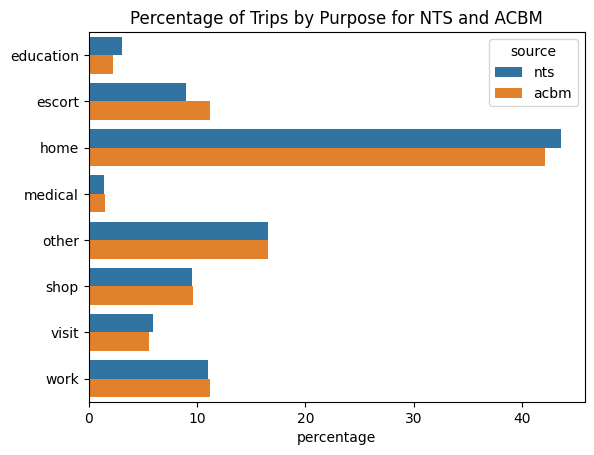

In [76]:
# Get number of trips by mode for legs_nts, and legs_acbm, and plot a comparative bar plot

# NTS
purpose_nts = legs_nts.groupby("dact").size().reset_index(name="count")
purpose_nts["source"] = "nts"

# ACBM
purpose_acbm = legs_acbm.groupby("dact").size().reset_index(name="count")
purpose_acbm["source"] = "acbm"

# Combine the data
purpose_compare = pd.concat([purpose_nts, purpose_acbm])

# Calculate the percentage of trips for each mode within each source
purpose_compare["percentage"] = purpose_compare.groupby("source")["count"].transform(lambda x: (x / x.sum()) * 100)


sns.barplot(data=purpose_compare, x="percentage",  y="dact", hue="source")
plt.ylabel('')
plt.title('Percentage of Trips by Purpose for NTS and ACBM')
plt.show()

## Matching: Trip Mode 



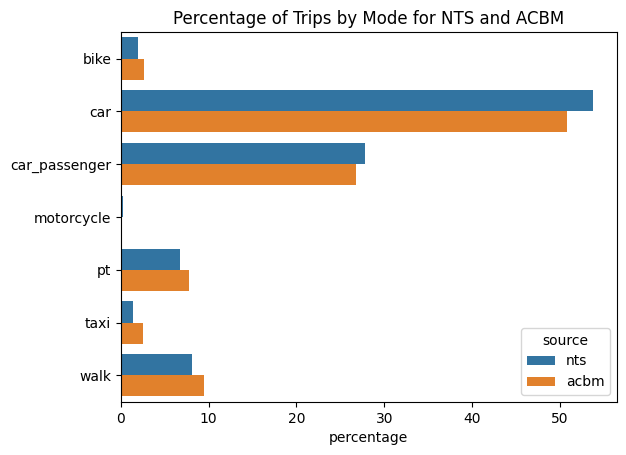

In [75]:
# Get number of trips by mode for legs_nts, and legs_acbm, and plot a comparative bar plot

# NTS
modeshare_nts = legs_nts.groupby("mode").size().reset_index(name="count")
modeshare_nts["source"] = "nts"

# ACBM
modeshare_acbm = legs_acbm.groupby("mode").size().reset_index(name="count")
modeshare_acbm["source"] = "acbm"

# Combine the data
modeshare_compare = pd.concat([modeshare_nts, modeshare_acbm])

# Calculate the percentage of trips for each mode within each source
modeshare_compare["percentage"] = modeshare_compare.groupby("source")["count"].transform(lambda x: (x / x.sum()) * 100)


sns.barplot(data=modeshare_compare, x="percentage", y="mode", hue="source")
plt.ylabel('')
plt.title('Percentage of Trips by Mode for NTS and ACBM')
plt.show()

## Matching: Time of Day 

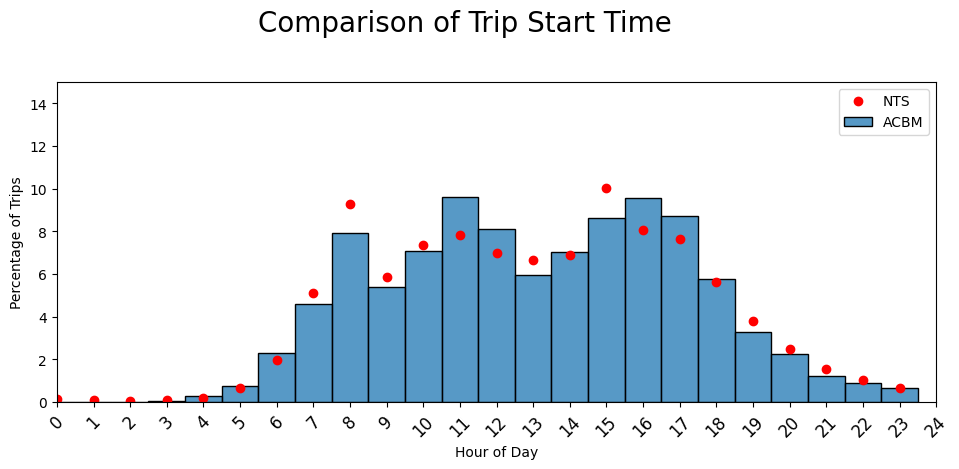

In [61]:
# Plot aggregate
plot_comparison(
    legs_acbm,
    legs_nts,
    value_column="tst_hour",
    max_y_value=15,
    plot_type="time",
    figsize=(10, 5),
    plot_mode="aggregate",
)

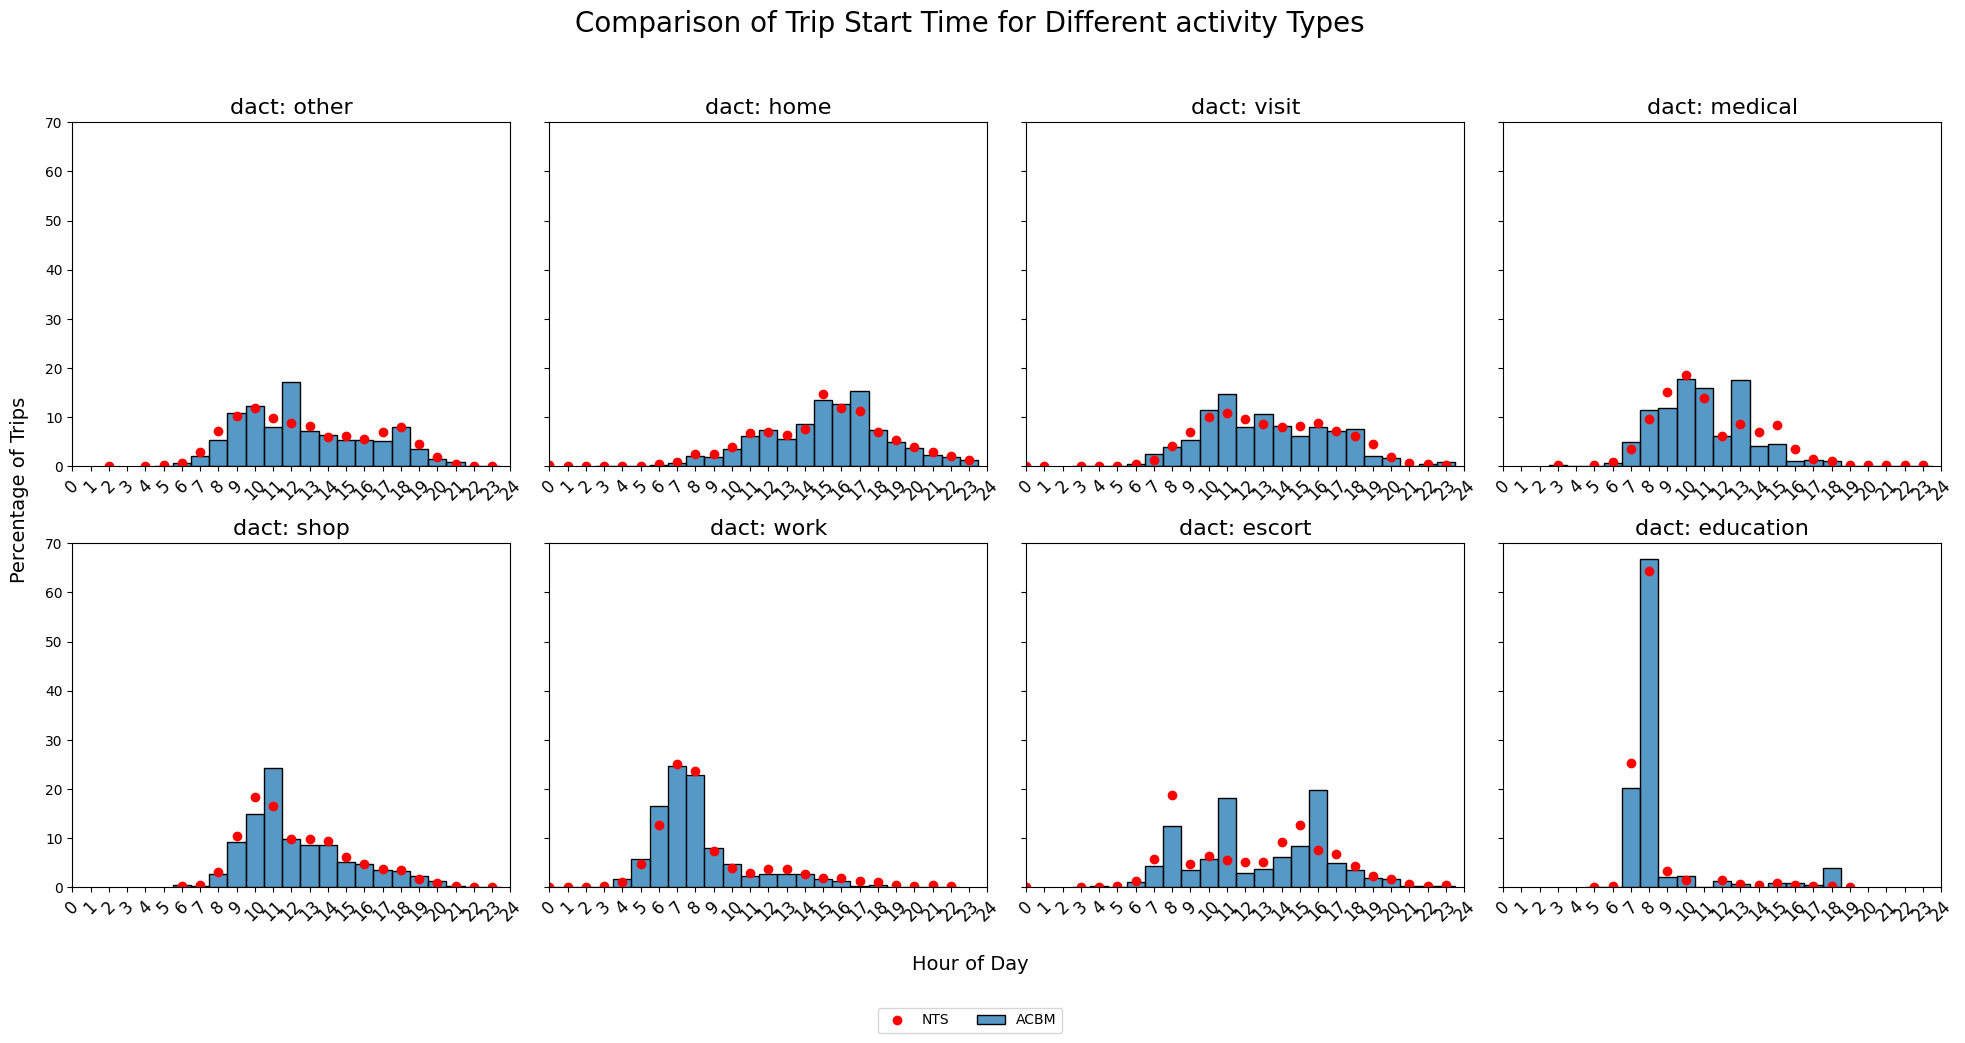

In [62]:
# Plot facet
plot_comparison(
    legs_acbm,
    legs_nts,
    value_column="tst_hour",
    max_y_value=70,
    plot_type="time",
    plot_mode="facet",
)

## Matching: Activity Sequences

Create chains from data and count number of observations of each chain

In [63]:
sequence_nts = process_sequences(
    df=legs_nts,
    pid_col="IndividualID",
    seq_col="seq",
    origin_activity_col="oact_abr",
    destination_activity_col="dact_abr",
    suffix="nts",
)

sequence_nts

,activity_sequence,count_nts
0,e - e - e - h - o - h,1
1,e - h,5
2,e - h - e,3
3,e - h - e - h,3
4,e - h - h - w - h,1
...,...,...
1144,w - w - w - h - o - h,1
1145,w - w - w - h - o - h - o - h,1
1146,w - w - w - h - w - w - h - w - h,1
1147,w - w - w - sh - w,1


In [64]:
sequence_acbm = process_sequences(
    df=legs_acbm,
    pid_col="pid",
    seq_col="seq",
    origin_activity_col="oact_abr",
    destination_activity_col="dact_abr",
    suffix="acbm",
)

sequence_acbm
                                  

,activity_sequence,count_acbm
0,h - e,266
1,h - e - e,25
2,h - e - e - e - e - e - e - h,8
3,h - e - e - e - e - v - e - h - o - h,40
4,h - e - e - e - h,653
...,...,...
917,h - w - w - w - w - h,29
918,h - w - w - w - w - h - w - w - w - w - h,41
919,h - w - w - w - w - w - h,42
920,h - w - w - w - w - w - w - h - m - h,5


Plot the comparison

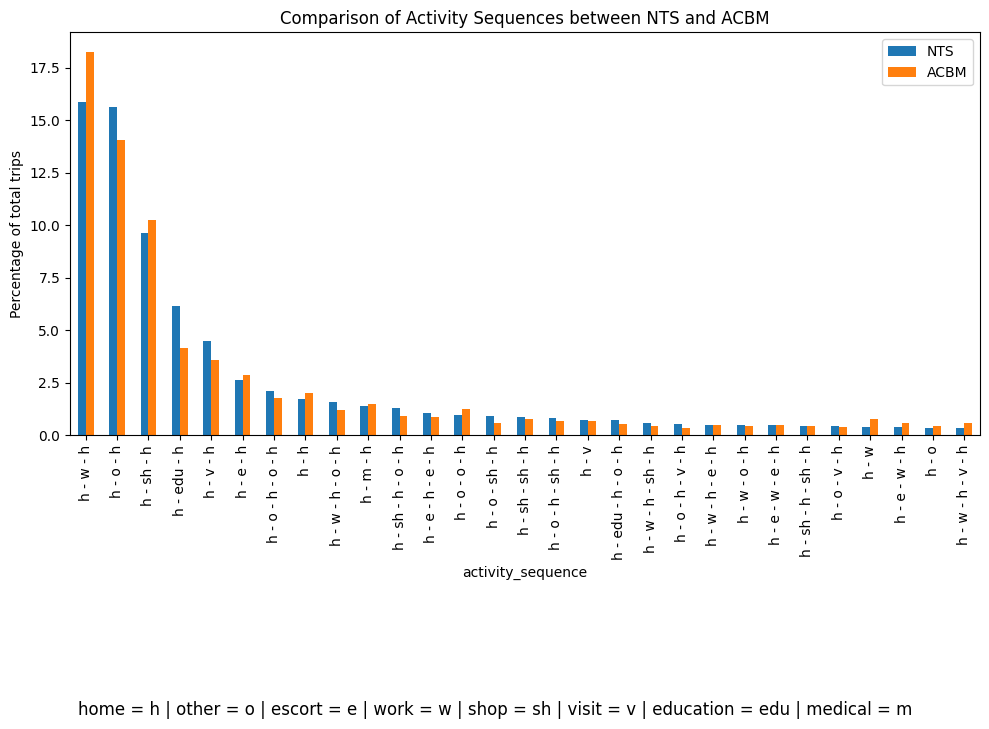

In [65]:
plot_activity_sequence_comparison(
    sequence_nts=sequence_nts,
    sequence_acbm=sequence_acbm,
    activity_mapping=activity_mapping,
    perc_cutoff=0.35,
    #save_path=validation_plots_path / "4_matching_activity_sequences.png",
)

## Assigning: Trip distances

### Mean crowfly distance per trip purpose

Calculate travel distance for acbm activities

In [66]:
# Apply the function to legs_acbm_geo
legs_acbm_geo = calculate_od_distances(
    df=legs_acbm_geo,
    start_wkt_col="start_location_geometry_wkt",
    end_wkt_col="end_location_geometry_wkt",
    crs_epsg=3857, #config.output_crs,
    detour_factor=1.56,
    decay_rate=0.0001
)

legs_acbm_geo.head(10)

,pid,hid,ozone,dzone,purp,oact,dact,mode,seq,tst,tet,duration,start_location_id,end_location_id,start_location_geometry_wkt,end_location_geometry_wkt,start_geometry,end_geometry,distance
0,0,0,E02002330,E02006875,other,home,other,car,1.0,1900-01-01 14:00:00,1900-01-01 14:20:00,0:20:00,1328970162,156862412,POINT (-167397.56531315646 7143640.45559949),POINT (-172747.9714739804 7132434.416198847),POINT (-167397.565 7143640.456),POINT (-172747.9714739804 7132434.416198847),14.4
1,0,0,E02006875,E02002330,home,other,home,car,2.0,1900-01-01 15:50:00,1900-01-01 16:15:00,0:25:00,156862412,1328970162,POINT (-172747.9714739804 7132434.416198847),POINT (-167397.56531315646 7143640.45559949),POINT (-172747.971 7132434.416),POINT (-167397.56531315646 7143640.45559949),14.4
2,1,0,E02002330,E02006875,visit,home,visit,car,1.0,1900-01-01 11:00:00,1900-01-01 11:10:00,0:10:00,1328970162,409680918,POINT (-167397.56531315646 7143640.45559949),POINT (-171612.75557645917 7131493.781319563),POINT (-167397.565 7143640.456),POINT (-171612.75557645917 7131493.781319563),14.8
3,1,0,E02006875,E02002330,home,visit,home,car,2.0,1900-01-01 14:15:00,1900-01-01 14:30:00,0:15:00,409680918,1328970162,POINT (-171612.75557645917 7131493.781319563),POINT (-167397.56531315646 7143640.45559949),POINT (-171612.756 7131493.781),POINT (-167397.56531315646 7143640.45559949),14.8
4,2,1,E02002330,E02002397,other,home,other,car,1.0,1900-01-01 12:00:00,1900-01-01 12:20:00,0:20:00,1364157198,925560630,POINT (-165837.93994546734 7146289.198739764),POINT (-183021.9284963755 7132485.554951054),POINT (-165837.940 7146289.199),POINT (-183021.9284963755 7132485.554951054),23.4
5,2,1,E02002397,E02002330,home,other,home,car,2.0,1900-01-01 15:45:00,1900-01-01 16:00:00,0:15:00,925560630,1364157198,POINT (-183021.9284963755 7132485.554951054),POINT (-165837.93994546734 7146289.198739764),POINT (-183021.928 7132485.555),POINT (-165837.93994546734 7146289.198739764),23.4
6,6,3,E02002330,E02002385,medical,home,medical,car,1.0,1900-01-01 10:55:00,1900-01-01 11:00:00,0:05:00,1329148862,466048244,POINT (-167076.14433525162 7143380.874507777),POINT (-176261.9486693152 7133639.7252226295),POINT (-167076.144 7143380.875),POINT (-176261.9486693152 7133639.7252226295),15.4
7,6,3,E02002385,E02002330,home,medical,home,car,2.0,1900-01-01 11:35:00,1900-01-01 11:40:00,0:05:00,466048244,1329148862,POINT (-176261.9486693152 7133639.7252226295),POINT (-167076.14433525162 7143380.874507777),POINT (-176261.949 7133639.725),POINT (-167076.14433525162 7143380.874507777),15.4
8,7,3,E02002330,E02002408,visit,home,visit,car,1.0,1900-01-01 13:30:00,1900-01-01 14:00:00,0:30:00,1329148862,922643356,POINT (-167076.14433525162 7143380.874507777),POINT (-184894.54901567698 7131835.651111132),POINT (-167076.144 7143380.875),POINT (-184894.54901567698 7131835.651111132),22.7
9,7,3,E02002408,E02002407,shop,visit,shop,car,2.0,1900-01-01 14:30:00,1900-01-01 14:40:00,0:10:00,922643356,1045869216,POINT (-184894.54901567698 7131835.651111132),POINT (-177180.48196898878 7131128.179195937),POINT (-184894.549 7131835.651),POINT (-177180.48196898878 7131128.179195937),9.7


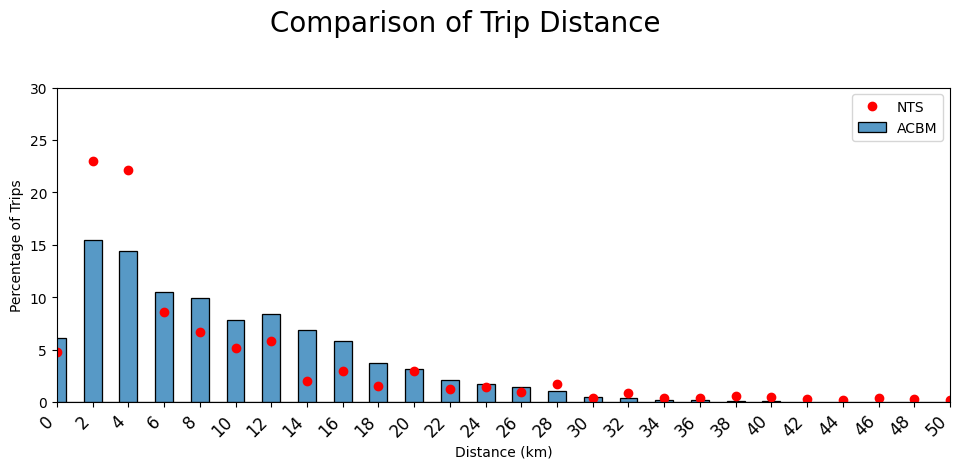

In [67]:
# Plot: Aggregate
plot_comparison(
    legs_acbm_geo,
    legs_nts,
    value_column="distance",
    bin_size=2,
    value_threshold=50,
    max_y_value=30,
    figsize=(10, 5),
    plot_type="distance",
    plot_mode="aggregate",
    )


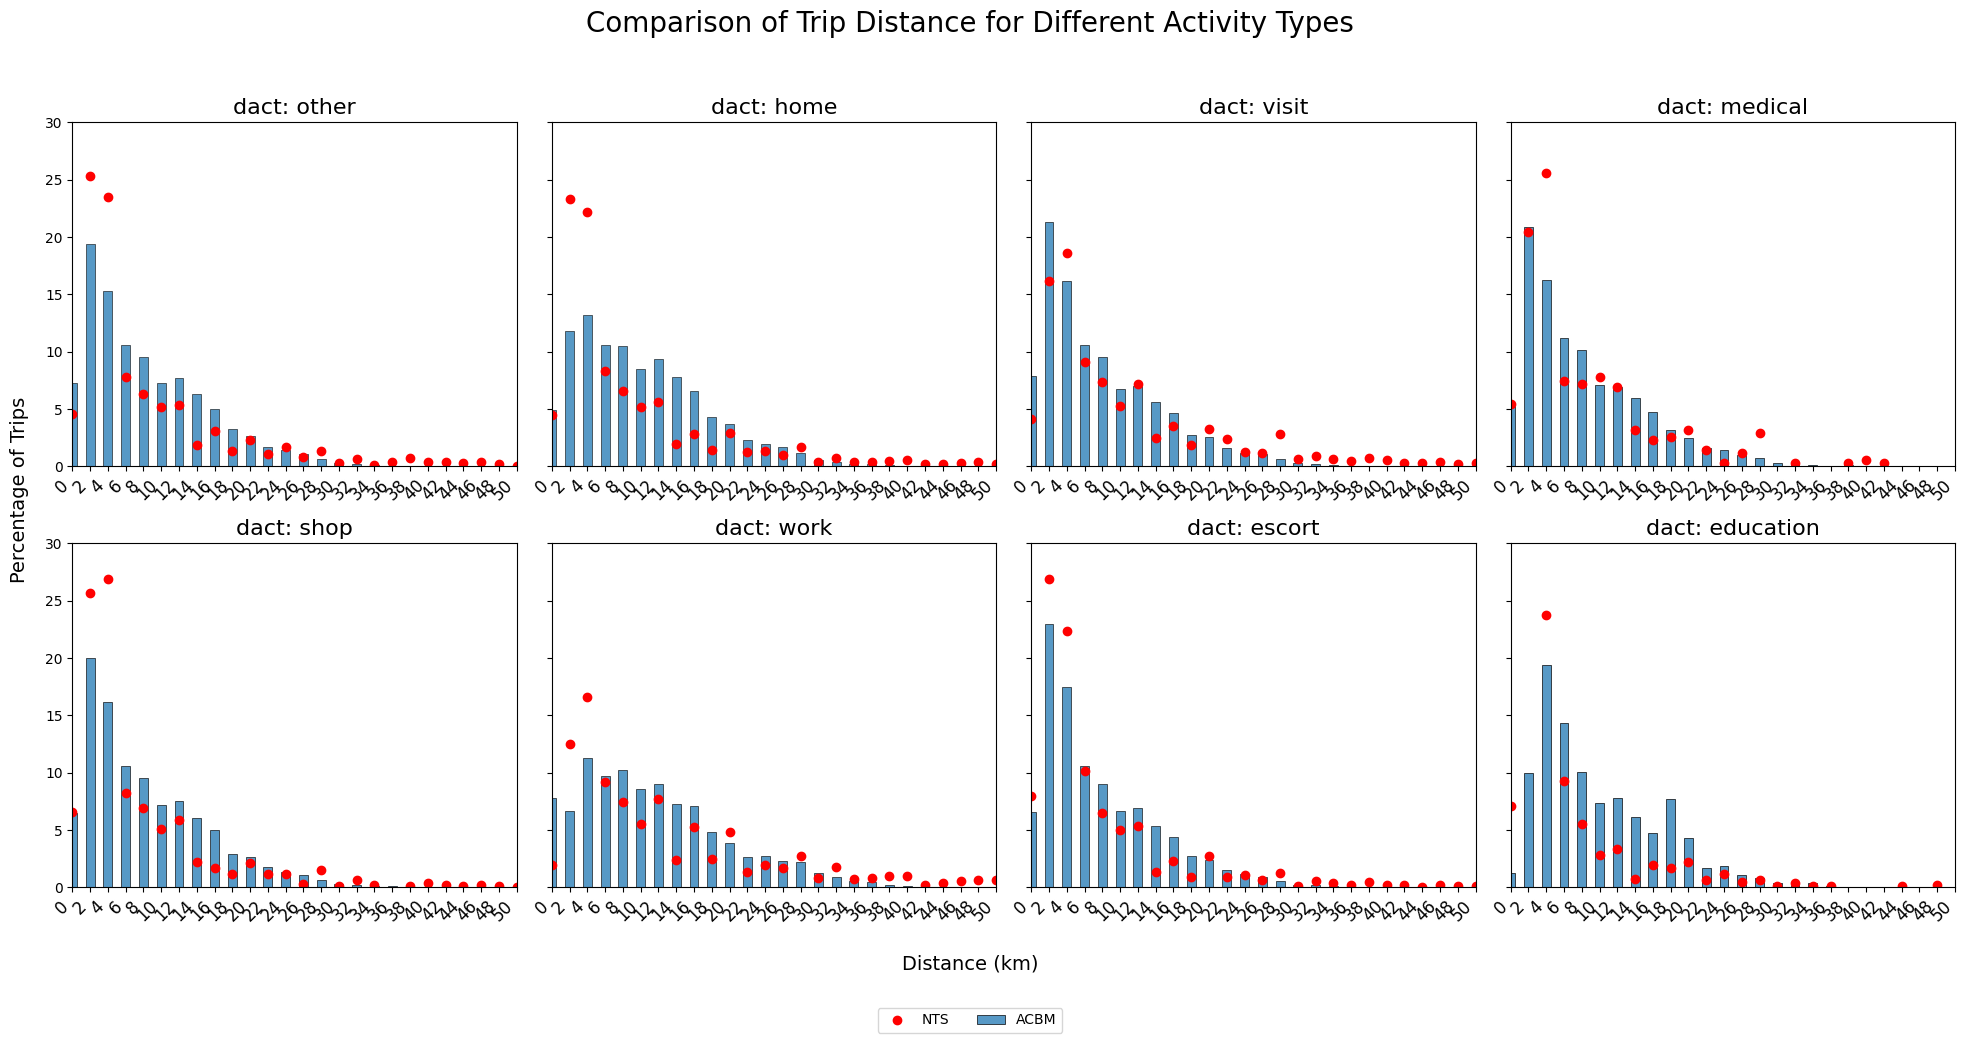

In [68]:
# Plot: Facet by activity_type
plot_comparison(
    legs_acbm_geo,
    legs_nts,
    value_column="distance",
    bin_size=2,
    value_threshold=50,
    max_y_value=30,
    plot_type="distance",
    plot_mode="facet",
)

### Test number of intrazonal trips

To ensure that our intrazonal logic is working. It appears we are underestimating the number of trips that are 2-4km and 4-6km. 

This could also be a result of travel times not correlating directly with distance, and that effect being more pronounced in shorter trips.


#### Plot intrazonal trips by trip purpose

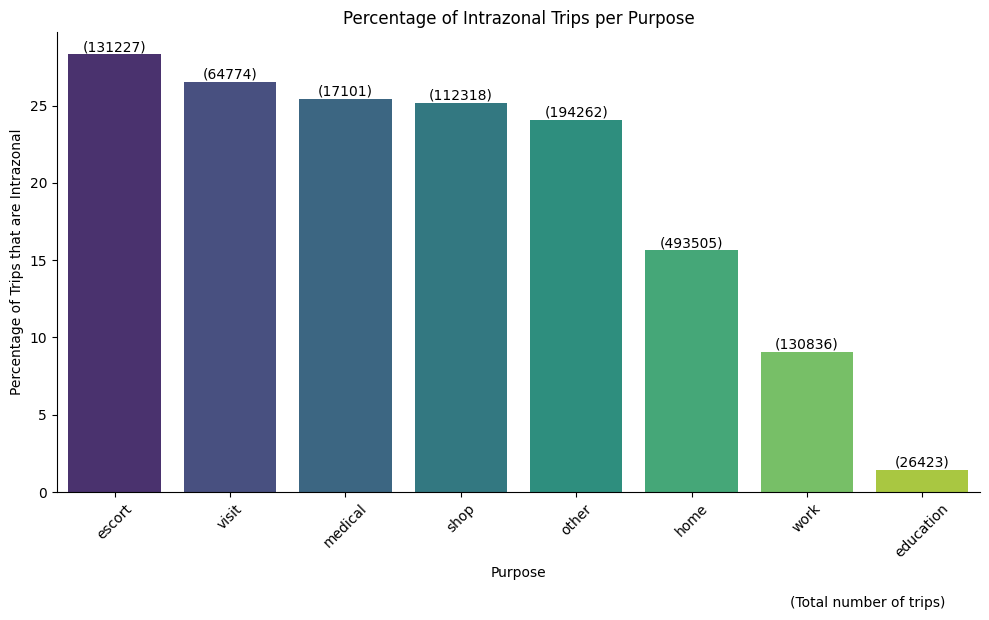

In [69]:
# Calculate the percentage of intrazonal trips for each unique purpose
plot_intrazonal_trips(
    legs_acbm,
    validation_plots_path=validation_plots_path,
    plot_type="purp",
)

#### Plot intrazonal trips by OD pair

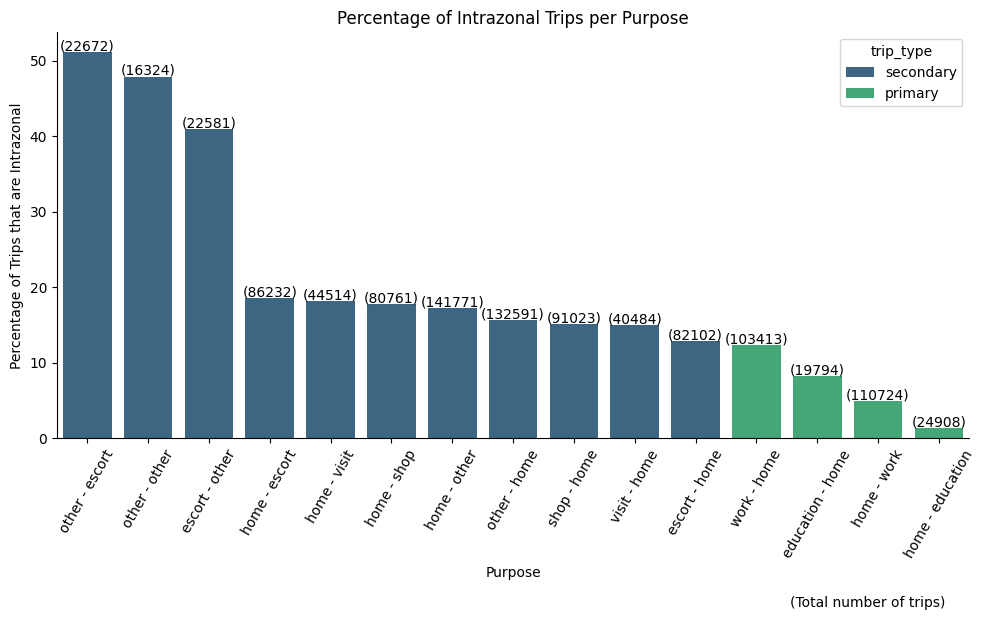

In [70]:
# Calculate the percentage of intrazonal trips for each unique OD combination
# (e.g. home - work)
plot_intrazonal_trips(
    legs_acbm,
    validation_plots_path=validation_plots_path,
    plot_type="od",
)
